In [2]:
# !tensorboard --logdir=/PATH_to_log_dir/ --port 6006

In [3]:
import torch
torch.__version__

'1.1.0'

In [4]:
# pip install -q tb-nightly

In [5]:
# pip install --upgrade torch torchvision

In [6]:
# pip list | grep tensor

In [7]:
%load_ext tensorboard

In [8]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

PATH_to_log_dir = '/data/cv_final/CT-Predict/2D-Pretrain/result' # 如果输出路径不存在会被自动创建
# writer = SummaryWriter(PATH_to_log_dir)
writer = SummaryWriter()


# for n_iter in range(100):
#     writer.add_scalar('Loss/train', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/train', np.random.random(), n_iter)

In [9]:
# %tensorboard --logdir=runs

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [11]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [12]:
batchsize=8
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        - root_dir /data/Data/
            - COVID19
                - img1.png
                - img2.png
                - ......
            - Normal
                - img1.png
                - img2.png
                - ......
        txt_path:
        - COVID19
            - test_COVID.txt
            - train_COVID.txt
            - val_COVID.txt
        - Normal
            - ...
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        # 2019
#         self.classes = ['COVID19', 'Normal']
        # UCSD
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
#             print(cls_list)
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample


# /data/COVID-CT/Data
#     /data/COVID-CT/Data-split/COVID/trainCT_COVID.txt
#     /data/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt
if __name__ == '__main__':
#     trainset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
#                               txt_COVID='/data/COVID-CT/Data-split/COVID/trainCT_COVID.txt',
#                               txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
#                               transform= train_transformer)
#     valset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
#                               txt_COVID='/data/COVID-CT/Data-split/COVID/valCT_COVID.txt',
#                               txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
#                               transform= val_transformer)
#     testset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
#                               txt_COVID='/data/COVID-CT/Data-split/COVID/testCT_COVID.txt',
#                               txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
#                               transform= val_transformer)
    
    trainset = CovidCTDataset(root_dir='/data/Data/',
                              txt_COVID='/data/Data/Data_split/COVID19/COVID19_train.txt',
                              txt_NonCOVID='/data/Data/Data_split/Normal/Normal_train.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='/data/Data',
                              txt_COVID='/data/Data/Data_split/COVID19/COVID19_val.txt',
                              txt_NonCOVID='/data/Data/Data_split/Normal/Normal_val.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='/data/Data',
                              txt_COVID='/data/Data/Data_split/COVID19/COVID19_test.txt',
                              txt_NonCOVID='/data/Data/Data_split/Normal/Normal_test.txt',
                              transform= val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

349
99
51


torch.Size([8, 3, 224, 224])


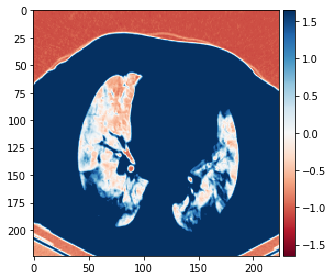

In [13]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
        break
# io.imread 读出图片格式是 uint8(unsigned int) ；value是 numpy array ；
# 图像数据是以 RGB 的格式进行存储的，通道值默认范围0-255
skimage.io.imshow(data[0,1,:,:].numpy())
print(data.shape)

In [14]:
# # pic = np.empty()
# for batch_index, batch_samples in enumerate(train_loader):      
#         data, target = batch_samples['img'], batch_samples['label']
#         for i in target:
#             if i.numpy() == 1:
#                 pic1 = data[0,1,:,:].numpy()
#             break
# # io.imread 读出图片格式是 uint8(unsigned int) ；value是 numpy array ；
# # 图像数据是以 RGB 的格式进行存储的，通道值默认范围0-255
# skimage.io.imshow(pic1)
# print(data.shape)

In [15]:
# for batch_index, batch_samples in enumerate(train_loader):      
#         data, target = batch_samples['img'], batch_samples['label']
#         if target[0].numpy() == 0:
#             pic2 = data[0,1,:,:].numpy()
#         break
# # io.imread 读出图片格式是 uint8(unsigned int) ；value是 numpy array ；
# # 图像数据是以 RGB 的格式进行存储的，通道值默认范围0-255
# skimage.io.imshow(pic2)
# print(data.shape)

In [16]:
# # mixup
# '''Use mixup to do data augmentation'''

# def mixup_data(x, y, alpha=1.0, use_cuda=True):
#     '''Returns mixed inputs, pairs of targets, and lambda'''
#     if alpha > 0:
#         lam = np.random.beta(alpha, alpha)
# #         print('lam',lam)
#     else:
#         lam = 1

#     batch_size = x.size()[0]
#     if use_cuda:
#         index = torch.randperm(batch_size).cuda()
#     else:
#         index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def mixup_criterion(criterion, pred, y_a, y_b, lam):
# #     print(pred)
# #     print(y_a)
# #     print('criterion',criterion(pred, y_a))
#     return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [17]:
his = {}
his['train_loss'] = []
his['train_acc'] = []
his['val_loss'] = []
his['val_acc'] = []
his['test_loss'] = []
his['test_acc'] = []

In [18]:
PATH_to_log_dir =  '/data/cv_final/CT-Predict/2D-Pretrain/result'

In [19]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    his['train_loss'].append(train_loss.data.cpu().numpy()/len(train_loader.dataset))
    his['train_acc'].append(train_correct / len(train_loader.dataset))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
    p = os.path.join(PATH_to_log_dir,'/{}.txt'.format(modelname))
    f = open(p, 'a+')
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f.write('\n')
    f.close()

In [20]:
# #val process is defined here

def val(epoch):
    
    model.eval()
    val_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            val_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        his['val_loss'].append(val_loss.data.cpu().numpy()/len(val_loader.dataset))
        his['val_acc'].append(correct/len(val_loader.dataset))       
    return targetlist, scorelist, predlist


In [21]:
# test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        his['test_loss'].append(test_loss.data.cpu().numpy()/len(test_loader.dataset))
        his['test_acc'].append(correct/len(test_loader.dataset))
    return targetlist, scorelist, predlist
    

In [22]:
# # model['']
# for k, v in model.items():
#     print(k, v.size(), sep='\t')
# # model.items()

In [23]:
# ### Dense169
# import torchvision.models as models
# # model = models.densenet169(pretrained=True).cuda()
# # # modelname = 'Dense169'

# """load MoCo pretrained model"""
# checkpoint = torch.load('new_data/save_model_dense/checkpoint_luna_covid_moco.pth.tar')
# # # # print(checkpoint.keys())
# # # # print(checkpoint['arch'])

# state_dict = checkpoint['state_dict']
# for key in list(state_dict.keys()):
#     if 'module.encoder_q' in key:
# #         print(key[17:])
#         new_key = key[17:]
#         state_dict[new_key] = state_dict[key]
#     del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'classifier.0.weight':
#         new_key = 'classifier.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.0.bias':
#         new_key = 'classifier.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
#         del state_dict[key]
# state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
# state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
# model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

In [24]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""

import torchvision.models as models

model = models.densenet169(pretrained=True).cuda()
# pretrained_net = torch.load('model_backup/Dense169.pt')
# pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
path = '/data/COVID-CT/baseline-methods/Self-Trans/Self-Trans.pt'
pretrained_net = torch.load(path)
''
model.load_state_dict(pretrained_net)

modelname = 'Dense169'

In [25]:
# net_dict = model.state_dict()  

In [26]:
# print(model)

In [27]:
# model.predict()

In [28]:
# from Dataset2D import CovidCTDataset

# #training process is defined here 
# batchsize=8
# alpha = None
# ## alpha is None if mixup is not used
# alpha_name = f'{alpha}'
# device = 'cuda'
# PATH_to_log_dir = '/data/cv_final/CT-Predict/2D-Pretrain/result' # 如果输出路径不存在会被自动创建

# trainset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
#                           txt_COVID='/data/COVID-CT/Data-split/COVID/trainCT_COVID.txt',
#                           txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
#                           transform= train_transformer)
# valset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
#                           txt_COVID='/data/COVID-CT/Data-split/COVID/valCT_COVID.txt',
#                           txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
#                           transform= val_transformer)
# testset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
#                           txt_COVID='/data/COVID-CT/Data-split/COVID/testCT_COVID.txt',
#                           txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
#                           transform= val_transformer)
# print(trainset.__len__())
# print(valset.__len__())
# print(testset.__len__())

# train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
# val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
# test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

In [29]:
# from UCSD_main import his, train, val, test

In [30]:
his = {}
his['train_loss'] = []
his['train_acc'] = []
his['val_loss'] = []
his['val_acc'] = []
his['test_loss'] = []
his['test_acc'] = []

In [31]:
import datetime
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

lr = 0.001
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 200
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "/data/cv_final/CT-Predict/2D-Pretrain/result/2019nCovR_{}_{}_{}_{}.pt".format(modelname,alpha_name,epoch, datetime.datetime.now()))  

        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open('/data/cv_final/CT-Predict/2D-Pretrain/result/2019nCovR_{}_{}_{}_{}.txt'.format(modelname,alpha_name, epoch, lr), 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))\
        
        f.close()

Train Epoch: 1 [0/44 (0%)]	Train Loss: 0.071794
Train Epoch: 1 [8/44 (18%)]	Train Loss: 0.035767
Train Epoch: 1 [16/44 (36%)]	Train Loss: 0.033588
Train Epoch: 1 [24/44 (55%)]	Train Loss: 0.039732
Train Epoch: 1 [32/44 (73%)]	Train Loss: 0.006063
Train Epoch: 1 [40/44 (91%)]	Train Loss: 0.010022
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.73945764e-08 1.02123031e-05 7.14532931e-08 7.02759644e-06
 5.81308015e-08 1.13917326e-04 5.24024824e-10 2.08131792e-06
 7.37760120e-09 4.49909248e-06 3.94026557e-07 3.41133871e-10
 2.56645993e-08 1.33836897e-09 1.00280658e-05 3.07455412e-06
 2.86881725e-04 3.79532721e-04 1.75475492e-04 5.47745405e-10
 1.88830640e-09 7.60094281e-08 1.66946743e-02 2.69653356e-06
 5.14717503e-05 1.256

Train Epoch: 5 [0/44 (0%)]	Train Loss: 0.019783
Train Epoch: 5 [8/44 (18%)]	Train Loss: 0.000624
Train Epoch: 5 [16/44 (36%)]	Train Loss: 0.057837
Train Epoch: 5 [24/44 (55%)]	Train Loss: 0.012068
Train Epoch: 5 [32/44 (73%)]	Train Loss: 0.059614
Train Epoch: 5 [40/44 (91%)]	Train Loss: 0.000284
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.56065298e-03 2.84139882e-03 7.20439712e-03 9.37572308e-03
 1.80108112e-03 9.13841203e-02 2.37565860e-03 3.72663984e-04
 4.35534661e-04 1.14259322e-03 9.93649126e-04 2.14913976e-03
 3.28144728e-04 1.04582973e-03 7.72045506e-03 2.80292681e-03
 5.24189323e-02 6.02300465e-03 2.03734520e-03 2.08610413e-03
 6.77945651e-03 1.24026544e-03 9.69287381e-02 1.65189710e-02
 7.03176064e-03 8.441

Train Epoch: 9 [0/44 (0%)]	Train Loss: 0.023995
Train Epoch: 9 [8/44 (18%)]	Train Loss: 0.010721
Train Epoch: 9 [16/44 (36%)]	Train Loss: 0.000680
Train Epoch: 9 [24/44 (55%)]	Train Loss: 0.029999
Train Epoch: 9 [32/44 (73%)]	Train Loss: 0.003629
Train Epoch: 9 [40/44 (91%)]	Train Loss: 0.024462
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [9.68055133e-07 9.48901925e-06 2.29433645e-05 3.88997887e-06
 2.78628363e-06 1.11734676e-04 3.73859621e-06 2.73144360e-06
 2.27156477e-07 3.68681071e-07 1.18902086e-07 1.83788381e-06
 7.71197051e-07 2.68564963e-06 2.86488762e-06 3.14317867e-06
 9.94513903e-05 2.88561750e-06 4.58179966e-06 3.37145792e-07
 1.74822560e-06 1.29749128e-06 1.67002581e-04 2.37594168e-06
 1.74219076e-05 2.903

Train Epoch: 13 [0/44 (0%)]	Train Loss: 0.001367
Train Epoch: 13 [8/44 (18%)]	Train Loss: 0.012462
Train Epoch: 13 [16/44 (36%)]	Train Loss: 0.013061
Train Epoch: 13 [24/44 (55%)]	Train Loss: 0.007876
Train Epoch: 13 [32/44 (73%)]	Train Loss: 0.006110
Train Epoch: 13 [40/44 (91%)]	Train Loss: 0.005025
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.09891078 0.13256641 0.12671611 0.04625813 0.09804817 0.10895976
 0.05750524 0.0621838  0.04863256 0.0334703  0.05088124 0.11101457
 0.0673298  0.16256133 0.02809635 0.05809883 0.09007173 0.02241551
 0.07027776 0.04671832 0.04058293 0.09252287 0.08102644 0.03855038
 0.04731059 0.08206864 0.02981579 0.03001727 0.06229711 0.10090351
 0.11599296 0.09518056 0.99996674 0.9999491  0

Train Epoch: 17 [0/44 (0%)]	Train Loss: 0.001390
Train Epoch: 17 [8/44 (18%)]	Train Loss: 0.000532
Train Epoch: 17 [16/44 (36%)]	Train Loss: 0.028227
Train Epoch: 17 [24/44 (55%)]	Train Loss: 0.000154
Train Epoch: 17 [32/44 (73%)]	Train Loss: 0.003515
Train Epoch: 17 [40/44 (91%)]	Train Loss: 0.003180
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [3.40112565e-05 7.17816991e-04 3.70106311e-04 8.70014483e-04
 4.28194398e-05 2.83071189e-03 1.73939188e-05 3.28757160e-05
 4.44147690e-06 4.38859024e-05 1.67042253e-05 5.35716281e-05
 7.52618826e-06 3.03762736e-05 2.97701190e-04 1.58271476e-04
 5.53730410e-04 3.13457822e-05 8.59057327e-05 3.82851140e-05
 2.26173273e-04 9.94267320e-05 3.92190367e-03 5.01336239e-04
 6.82034413e-04


 The epoch is 20, average recall: 1.0000, average precision: 1.0000,average F1: 1.0000, average accuracy: 1.0000, average AUC: 1.0000
Train Epoch: 21 [0/44 (0%)]	Train Loss: 0.001208
Train Epoch: 21 [8/44 (18%)]	Train Loss: 0.004425
Train Epoch: 21 [16/44 (36%)]	Train Loss: 0.002743
Train Epoch: 21 [24/44 (55%)]	Train Loss: 0.000322
Train Epoch: 21 [32/44 (73%)]	Train Loss: 0.001369
Train Epoch: 21 [40/44 (91%)]	Train Loss: 0.002038
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [2.47684657e-03 2.46017184e-02 1.48500893e-02 2.35460475e-02
 1.00103803e-02 1.13500662e-01 3.62348394e-03 2.29879864e-03
 2.20241188e-03 7.03085400e-03 2.03923928e-03 3.69817950e-03
 2.16878345e-03 3.00445873e-03 1.83014181e-02 1.03764730e-02
 8

Train Epoch: 25 [0/44 (0%)]	Train Loss: 0.006151
Train Epoch: 25 [8/44 (18%)]	Train Loss: 0.025700
Train Epoch: 25 [16/44 (36%)]	Train Loss: 0.088281
Train Epoch: 25 [24/44 (55%)]	Train Loss: 0.002778
Train Epoch: 25 [32/44 (73%)]	Train Loss: 0.001074
Train Epoch: 25 [40/44 (91%)]	Train Loss: 0.004282
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.99196802e-04 3.08902678e-03 9.82496073e-04 4.51089721e-03
 1.53545858e-04 1.24406051e-02 6.64956751e-05 5.19949863e-05
 1.29898719e-04 5.92784345e-05 4.98366644e-05 4.96942201e-04
 2.73232381e-05 1.25797349e-03 9.35459684e-04 1.03615326e-04
 1.27979193e-03 2.66319636e-04 2.55734427e-04 2.34115520e-04
 9.03992739e-04 2.31398517e-04 3.33867036e-02 3.25278379e-03
 2.36885599e-03

Train Epoch: 29 [0/44 (0%)]	Train Loss: 0.001940
Train Epoch: 29 [8/44 (18%)]	Train Loss: 0.000648
Train Epoch: 29 [16/44 (36%)]	Train Loss: 0.000565
Train Epoch: 29 [24/44 (55%)]	Train Loss: 0.002705
Train Epoch: 29 [32/44 (73%)]	Train Loss: 0.011592
Train Epoch: 29 [40/44 (91%)]	Train Loss: 0.015112
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.31168747e-02 1.70610808e-02 5.07893339e-02 5.57017699e-02
 4.79547530e-02 1.86796769e-01 5.85976895e-03 7.93037005e-03
 2.17071082e-03 2.72545572e-02 2.48171715e-03 1.24393459e-02
 4.34162747e-03 4.04514885e-03 7.97886252e-02 2.00205427e-02
 1.06506228e-01 1.35473441e-02 2.21984256e-02 1.69531181e-02
 3.10433153e-02 6.01540506e-03 1.75761759e-01 1.91769972e-02
 4.28676493e-02

Train Epoch: 32 [8/44 (18%)]	Train Loss: 0.000605
Train Epoch: 32 [16/44 (36%)]	Train Loss: 0.001973
Train Epoch: 32 [24/44 (55%)]	Train Loss: 0.000874
Train Epoch: 32 [32/44 (73%)]	Train Loss: 0.024305
Train Epoch: 32 [40/44 (91%)]	Train Loss: 0.004014
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [3.70343332e-06 7.37491937e-05 5.45750154e-05 9.95413284e-05
 1.02289414e-05 2.31360595e-04 2.48793594e-06 2.93604171e-06
 1.24906046e-06 5.61123306e-06 9.08199866e-07 6.69195060e-06
 7.57367673e-07 6.41871338e-06 1.01026984e-04 2.21143819e-05
 5.05156895e-05 2.74500189e-06 3.72257546e-06 2.75525417e-06
 8.54688260e-05 1.31272327e-05 1.25371886e-03 2.23617099e-04
 3.72625596e-04 7.79694892e-05 2.38235612e-06 6.31326810e-04
 1.

Train Epoch: 36 [0/44 (0%)]	Train Loss: 0.003316
Train Epoch: 36 [8/44 (18%)]	Train Loss: 0.000436
Train Epoch: 36 [16/44 (36%)]	Train Loss: 0.000602
Train Epoch: 36 [24/44 (55%)]	Train Loss: 0.002732
Train Epoch: 36 [32/44 (73%)]	Train Loss: 0.000091
Train Epoch: 36 [40/44 (91%)]	Train Loss: 0.000378
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.00942479 0.01652667 0.0291954  0.05625052 0.01547287 0.35099754
 0.00915482 0.00481254 0.00583118 0.01204259 0.00564763 0.01477922
 0.00302227 0.00482493 0.02374581 0.00964682 0.15586941 0.02522457
 0.02729573 0.01535464 0.03376314 0.01180143 0.25376588 0.04291533
 0.05454207 0.04902584 0.04144225 0.29654041 0.02540413 0.0251384
 0.00550354 0.00124063 1.         1.         1.

Train Epoch: 40 [0/44 (0%)]	Train Loss: 0.002060
Train Epoch: 40 [8/44 (18%)]	Train Loss: 0.001979
Train Epoch: 40 [16/44 (36%)]	Train Loss: 0.000216
Train Epoch: 40 [24/44 (55%)]	Train Loss: 0.003877
Train Epoch: 40 [32/44 (73%)]	Train Loss: 0.009477
Train Epoch: 40 [40/44 (91%)]	Train Loss: 0.001247
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [5.13604516e-03 6.57608872e-03 1.25162750e-02 5.27330525e-02
 1.29637579e-02 2.86960512e-01 2.11816002e-03 2.33244449e-02
 1.47605117e-03 2.48393733e-02 2.59943446e-03 7.44146248e-03
 4.00495669e-03 1.80024712e-03 3.11678983e-02 1.83460843e-02
 2.29727909e-01 2.63949092e-02 3.31704691e-02 4.74213576e-03
 2.19917987e-02 5.11883851e-03 2.03930318e-01 2.33621784e-02
 1.02320254e-01

Train Epoch: 44 [0/44 (0%)]	Train Loss: 0.009491
Train Epoch: 44 [8/44 (18%)]	Train Loss: 0.008130
Train Epoch: 44 [16/44 (36%)]	Train Loss: 0.002524
Train Epoch: 44 [24/44 (55%)]	Train Loss: 0.009622
Train Epoch: 44 [32/44 (73%)]	Train Loss: 0.001388
Train Epoch: 44 [40/44 (91%)]	Train Loss: 0.017280
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.02063958 0.06237722 0.05885167 0.10215986 0.02491964 0.36511797
 0.02675272 0.0272041  0.00889745 0.0200724  0.00945283 0.0260847
 0.01005862 0.02800076 0.0566326  0.03819266 0.28918806 0.05396331
 0.07268356 0.02595504 0.03685605 0.0239176  0.32398641 0.06996258
 0.08022527 0.10427203 0.07942671 0.23034553 0.07780302 0.05539207
 0.0172423  0.00494159 0.99997103 0.99992955 0.

Train Epoch: 48 [0/44 (0%)]	Train Loss: 0.004577
Train Epoch: 48 [8/44 (18%)]	Train Loss: 0.000120
Train Epoch: 48 [16/44 (36%)]	Train Loss: 0.008325
Train Epoch: 48 [24/44 (55%)]	Train Loss: 0.002564
Train Epoch: 48 [32/44 (73%)]	Train Loss: 0.001680
Train Epoch: 48 [40/44 (91%)]	Train Loss: 0.007527
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [5.50421840e-03 2.60339249e-02 2.25432590e-02 3.09252858e-01
 3.11240125e-02 8.38993132e-01 3.76867061e-03 3.70924957e-02
 1.38101727e-03 3.88273746e-02 2.03590002e-03 8.35373532e-03
 2.43758247e-03 3.35576176e-03 1.49815544e-01 5.11916317e-02
 2.49937654e-01 1.06617987e-01 9.34075639e-02 7.50258425e-03
 5.41403629e-02 1.11061540e-02 7.34025657e-01 1.57788843e-01
 2.23229706e-01

Train Epoch: 51 [8/44 (18%)]	Train Loss: 0.000582
Train Epoch: 51 [16/44 (36%)]	Train Loss: 0.065770
Train Epoch: 51 [24/44 (55%)]	Train Loss: 0.005904
Train Epoch: 51 [32/44 (73%)]	Train Loss: 0.037070
Train Epoch: 51 [40/44 (91%)]	Train Loss: 0.003762
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [7.97890152e-06 2.42931783e-04 1.80086034e-04 1.42479036e-03
 6.94462360e-05 2.82820135e-01 6.36506547e-06 1.47436913e-05
 4.57620536e-06 2.01985549e-05 1.86124430e-06 1.58978528e-05
 1.71574504e-06 2.49149998e-05 3.33898613e-04 4.11704896e-05
 1.01628155e-02 5.35295476e-05 5.07379627e-05 3.45605145e-06
 1.83550408e-04 1.39978365e-05 2.87501097e-01 9.59467085e-04
 1.79682288e-03 8.71008262e-04 7.80115079e-05 3.55288535e-02
 1.

Train Epoch: 55 [0/44 (0%)]	Train Loss: 0.004667
Train Epoch: 55 [8/44 (18%)]	Train Loss: 0.014617
Train Epoch: 55 [16/44 (36%)]	Train Loss: 0.028877
Train Epoch: 55 [24/44 (55%)]	Train Loss: 0.008324
Train Epoch: 55 [32/44 (73%)]	Train Loss: 0.012194
Train Epoch: 55 [40/44 (91%)]	Train Loss: 0.001040
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.03635582e-04 2.43292248e-04 4.31883661e-03 2.30501108e-02
 1.50886539e-03 8.20477486e-01 1.92657433e-04 9.33413918e-04
 3.99063611e-05 1.38946518e-03 6.14828095e-05 2.22918810e-03
 7.86652308e-05 2.45686515e-05 5.98274544e-03 1.94325717e-03
 3.64313364e-01 4.01586248e-03 1.35623589e-02 3.69166846e-05
 3.73765873e-03 5.48824173e-05 6.48531795e-01 1.65809039e-02
 4.15149033e-02

Train Epoch: 59 [0/44 (0%)]	Train Loss: 0.000827
Train Epoch: 59 [8/44 (18%)]	Train Loss: 0.000214
Train Epoch: 59 [16/44 (36%)]	Train Loss: 0.001646
Train Epoch: 59 [24/44 (55%)]	Train Loss: 0.065860
Train Epoch: 59 [32/44 (73%)]	Train Loss: 0.004547
Train Epoch: 59 [40/44 (91%)]	Train Loss: 0.011318
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.01631093 0.03061437 0.0746165  0.25511715 0.04175022 0.56594932
 0.00395855 0.06620882 0.00418827 0.04281865 0.00850532 0.045594
 0.00774176 0.01400302 0.08089371 0.13097656 0.19862229 0.01526913
 0.03969744 0.02706692 0.21568245 0.02284013 0.54964608 0.09997272
 0.19845349 0.22933739 0.02080854 0.56060314 0.02913084 0.03236953
 0.04318858 0.01046416 0.9999969  0.9999938  0.9

Train Epoch: 63 [0/44 (0%)]	Train Loss: 0.000331
Train Epoch: 63 [8/44 (18%)]	Train Loss: 0.030083
Train Epoch: 63 [16/44 (36%)]	Train Loss: 0.004368
Train Epoch: 63 [24/44 (55%)]	Train Loss: 0.004100
Train Epoch: 63 [32/44 (73%)]	Train Loss: 0.006894
Train Epoch: 63 [40/44 (91%)]	Train Loss: 0.004748
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [5.49368677e-04 4.10169596e-04 4.33827331e-03 8.01573507e-03
 1.57577323e-03 3.66250694e-01 2.55315390e-04 1.09114381e-03
 5.88870207e-05 2.47339089e-03 2.03759497e-04 7.08670123e-04
 1.43151847e-04 7.64790311e-05 1.28334602e-02 1.56035274e-03
 6.22065291e-02 5.09846862e-03 5.44602191e-03 4.59312228e-04
 7.85883702e-03 6.52092975e-04 5.22767067e-01 1.44561119e-02
 1.69672463e-02

Train Epoch: 67 [0/44 (0%)]	Train Loss: 0.000554
Train Epoch: 67 [8/44 (18%)]	Train Loss: 0.000230
Train Epoch: 67 [16/44 (36%)]	Train Loss: 0.003202
Train Epoch: 67 [24/44 (55%)]	Train Loss: 0.000809
Train Epoch: 67 [32/44 (73%)]	Train Loss: 0.003721
Train Epoch: 67 [40/44 (91%)]	Train Loss: 0.003361
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.00604612 0.01636391 0.01241063 0.12896968 0.01743162 0.67033297
 0.0044928  0.03063312 0.00241983 0.01592043 0.00445704 0.00733521
 0.00322647 0.00403155 0.09566764 0.04635328 0.05141795 0.03448329
 0.02749726 0.01616745 0.04991844 0.00855451 0.19432718 0.04812473
 0.11080917 0.06901156 0.01135483 0.25304762 0.01003921 0.01299145
 0.00823669 0.00279838 0.99999964 1.         1


 The epoch is 70, average recall: 1.0000, average precision: 1.0000,average F1: 1.0000, average accuracy: 1.0000, average AUC: 1.0000
Train Epoch: 71 [0/44 (0%)]	Train Loss: 0.000050
Train Epoch: 71 [8/44 (18%)]	Train Loss: 0.000010
Train Epoch: 71 [16/44 (36%)]	Train Loss: 0.000337
Train Epoch: 71 [24/44 (55%)]	Train Loss: 0.000116
Train Epoch: 71 [32/44 (73%)]	Train Loss: 0.004351
Train Epoch: 71 [40/44 (91%)]	Train Loss: 0.001202
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.38970601e-04 1.33610808e-03 8.12053098e-04 2.90363673e-02
 7.76711525e-03 2.56791532e-01 1.96916005e-03 1.80547778e-02
 1.08537381e-04 2.71493755e-02 1.05928186e-04 8.48338241e-04
 6.65645755e-04 3.75699614e-07 6.32584020e-02 2.26003323e-02
 2

Train Epoch: 75 [0/44 (0%)]	Train Loss: 0.002013
Train Epoch: 75 [8/44 (18%)]	Train Loss: 0.007563
Train Epoch: 75 [16/44 (36%)]	Train Loss: 0.010127
Train Epoch: 75 [24/44 (55%)]	Train Loss: 0.020312
Train Epoch: 75 [32/44 (73%)]	Train Loss: 0.030162
Train Epoch: 75 [40/44 (91%)]	Train Loss: 0.014565
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [2.71761674e-03 8.83278996e-03 1.16885798e-02 1.20482333e-02
 7.91206490e-03 1.08800776e-01 9.04288143e-03 2.48025358e-03
 1.23737089e-03 1.10735390e-02 9.52576578e-04 3.28525226e-03
 4.57926420e-04 2.17315770e-04 1.69574991e-02 8.98483302e-03
 9.15980339e-02 1.18256174e-02 1.20353168e-02 1.66562002e-03
 1.18698822e-02 5.01473853e-03 1.40650257e-01 1.36271203e-02
 3.97384726e-02

Train Epoch: 79 [0/44 (0%)]	Train Loss: 0.000172
Train Epoch: 79 [8/44 (18%)]	Train Loss: 0.022813
Train Epoch: 79 [16/44 (36%)]	Train Loss: 0.001251
Train Epoch: 79 [24/44 (55%)]	Train Loss: 0.000723
Train Epoch: 79 [32/44 (73%)]	Train Loss: 0.000012
Train Epoch: 79 [40/44 (91%)]	Train Loss: 0.000415
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [8.31734156e-04 5.44955628e-03 2.66499957e-03 3.63936499e-02
 7.12145818e-03 1.32483259e-01 1.18786248e-03 1.64867379e-02
 1.25275680e-03 1.56924222e-02 4.43845463e-04 8.21752590e-04
 4.87904064e-04 3.98650096e-04 3.25319879e-02 2.04018746e-02
 8.03008378e-02 1.22487033e-02 1.01588052e-02 8.51041579e-04
 3.99292493e-03 1.63162593e-03 7.81031623e-02 8.03022087e-03
 4.64394353e-02

Train Epoch: 83 [0/44 (0%)]	Train Loss: 0.003109
Train Epoch: 83 [8/44 (18%)]	Train Loss: 0.000357
Train Epoch: 83 [16/44 (36%)]	Train Loss: 0.000002
Train Epoch: 83 [24/44 (55%)]	Train Loss: 0.000167
Train Epoch: 83 [32/44 (73%)]	Train Loss: 0.001055
Train Epoch: 83 [40/44 (91%)]	Train Loss: 0.004940
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [0.01420601 0.05819081 0.09631693 0.12527733 0.03342488 0.25775346
 0.00920759 0.03848947 0.00833361 0.01629868 0.00290481 0.02439638
 0.00499896 0.0073232  0.0974605  0.11179875 0.10257607 0.00921722
 0.01705942 0.01578989 0.10184192 0.02998222 0.25922346 0.04364731
 0.12137759 0.08130058 0.00578112 0.34225604 0.02235939 0.03271675
 0.0484869  0.006525   1.         1.         1

Train Epoch: 87 [0/44 (0%)]	Train Loss: 0.004975
Train Epoch: 87 [8/44 (18%)]	Train Loss: 0.000087
Train Epoch: 87 [16/44 (36%)]	Train Loss: 0.000876
Train Epoch: 87 [24/44 (55%)]	Train Loss: 0.001973
Train Epoch: 87 [32/44 (73%)]	Train Loss: 0.000017
Train Epoch: 87 [40/44 (91%)]	Train Loss: 0.017520
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [3.43267748e-05 7.81525858e-04 6.96192496e-04 4.53930208e-03
 1.37306066e-04 9.38228369e-02 2.33673272e-04 3.58048972e-04
 5.26036420e-05 1.31335386e-04 7.80321352e-06 4.93096653e-04
 2.83921381e-05 1.18765483e-05 4.27656481e-03 1.20561535e-03
 7.82899708e-02 7.60993629e-04 1.23328331e-03 1.16365220e-04
 1.70762511e-03 3.31012474e-04 1.63391396e-01 5.26790414e-03
 1.91717111e-02


 The epoch is 90, average recall: 1.0000, average precision: 1.0000,average F1: 1.0000, average accuracy: 1.0000, average AUC: 1.0000
Train Epoch: 91 [0/44 (0%)]	Train Loss: 0.001662
Train Epoch: 91 [8/44 (18%)]	Train Loss: 0.036519
Train Epoch: 91 [16/44 (36%)]	Train Loss: 0.001429
Train Epoch: 91 [24/44 (55%)]	Train Loss: 0.004986
Train Epoch: 91 [32/44 (73%)]	Train Loss: 0.000944
Train Epoch: 91 [40/44 (91%)]	Train Loss: 0.000316
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [9.31249931e-04 4.76956926e-03 9.59727075e-03 4.02918309e-02
 6.52682385e-04 6.79708347e-02 1.93157303e-03 3.88467888e-04
 4.07838925e-05 5.67420328e-04 1.03967170e-04 1.92870526e-03
 5.12461665e-05 6.94139962e-05 1.73307471e-02 3.92116560e-03
 2

Train Epoch: 95 [0/44 (0%)]	Train Loss: 0.000316
Train Epoch: 95 [8/44 (18%)]	Train Loss: 0.006270
Train Epoch: 95 [16/44 (36%)]	Train Loss: 0.004407
Train Epoch: 95 [24/44 (55%)]	Train Loss: 0.003300
Train Epoch: 95 [32/44 (73%)]	Train Loss: 0.000467
Train Epoch: 95 [40/44 (91%)]	Train Loss: 0.003709
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.10866991e-03 2.94032739e-03 6.62478758e-03 3.07010058e-02
 1.31273072e-03 1.65055305e-01 7.47224607e-04 2.36960431e-03
 1.56302762e-04 2.25517293e-03 3.04165238e-04 2.87889247e-03
 2.94413476e-04 1.73665641e-04 3.45527679e-02 4.60239267e-03
 3.48230936e-02 6.87657390e-03 1.12622194e-02 1.84918800e-03
 1.90879758e-02 1.85100373e-03 2.88027078e-01 2.98701413e-02
 6.85242712e-02

Train Epoch: 99 [0/44 (0%)]	Train Loss: 0.002544
Train Epoch: 99 [8/44 (18%)]	Train Loss: 0.022166
Train Epoch: 99 [16/44 (36%)]	Train Loss: 0.005194
Train Epoch: 99 [24/44 (55%)]	Train Loss: 0.005921
Train Epoch: 99 [32/44 (73%)]	Train Loss: 0.000171
Train Epoch: 99 [40/44 (91%)]	Train Loss: 0.000182
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.35798400e-04 8.65302922e-04 1.14112161e-03 7.40747992e-03
 7.19182368e-04 9.29531679e-02 1.12352092e-04 7.05061422e-04
 1.09190914e-05 4.40134812e-04 7.47187150e-05 4.46893944e-04
 1.57946670e-05 1.91100298e-05 9.36560426e-03 4.19684220e-03
 1.02262795e-02 1.38295279e-03 1.79031945e-03 2.48695345e-04
 3.06236115e-03 3.11436917e-04 1.57207340e-01 5.23974374e-03
 1.40182246e-02

KeyboardInterrupt: 

In [32]:
# test
import datetime
bs = 1
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)


save_p = os.path.join(PATH_to_log_dir, f'test_2019nCovR_{modelname}_{alpha}_{epoch}_{datetime.datetime.now()}.txt')
f = open(save_p, 'a+')
f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
epoch, r, p, F1, acc, AUC))
f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_wuhan.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
score [1.99752922e-05 1.59125957e-05 3.35764053e-04 6.10836491e-04
 3.12690507e-03 7.65410904e-03 1.47970102e-03 9.98349428e-01
 5.94628513e-01 1.32240891e-03 4.94448701e-03 3.24020395e-04
 1.79625431e-03 2.04854319e-03 8.17322070e-05 2.00040213e-05
 1.22769139e-04 9.99790132e-01 9.99904156e-01 9.99898314e-01
 9.99888420e-01 9.99835610e-01 9.99760449e-01 1.00000000e+00
 9.99999762e-01 9.97848988e-01 9.08311546e-01 1.06208123e-01
 9.93480325e-01 6.06321812e-01 6.67709470e-01 9.97837365e-01
 9.99983072e-01 9.98454571e-01 9.99999881e-01 9.99965668e-01
 6.43781185e-01 1.00000000e+00 9.84799266e-01 9.99999881e-01
 9.99691129e-01 9.99999166e-01 9.99995828e-01 9.99998927e-01
 1.00000000e+00 9.99270976e-01 6.42141104e-01 1.00000000e+00
 9.92815733e-01 9.99999523e-01 9.68293667e-01]
predict [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 

In [19]:
his

{'train_loss': [0.05249804412054811,
  0.039963796008965345,
  0.037613046203438395,
  0.047168835527917376,
  0.017122271409348976,
  0.022357842300546202,
  0.029495911475238962,
  0.022605636399933123,
  0.017053337698338025,
  0.017392867615707967,
  0.00976723859508263,
  0.01896333284569333,
  0.028046435817948044,
  0.013779712611419765,
  0.01360547576729411,
  0.013251792393987705,
  0.012793223974014762,
  0.0188345089341303,
  0.018117304859325334,
  0.011826515197753906,
  0.024337273955686727,
  0.019156876812691674,
  0.00868339524911263,
  0.012204582848316619,
  0.017494832888715246,
  0.013116139737104618,
  0.010002406073846244,
  0.009834180930282462,
  0.005036447314614894,
  0.008278537274773278,
  0.006865343596668845,
  0.006922486176805032,
  0.0084039454473807,
  0.011395371745855556,
  0.0061915002784619705,
  0.004839198295571401,
  0.010890860953781872,
  0.007112591177822867,
  0.008127137378157038,
  0.007452862993693967,
  0.012477617892289914,
  0.007930

55


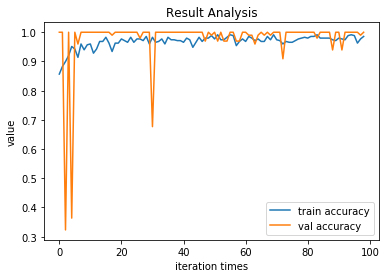

In [33]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


#x_axix，train_pn_dis这些都是长度相同的list()
# print(his['train_loss'])
x_axix = range(len(his['train_loss']))
#开始画图
# d = [ item/batchsize  for item in his['val_acc']]
# t = [item/4 for item in his['train_loss']]
val_acc = [
  0.82323232323232326, 0.84423232323232326,  0.83393232323232326, 0.82193232323232326, 0.80323232323232326, #   0.3333333333333333,
  0.896969696969697,0.8871717171717171,0.8271717171717171, 0.8371717171717171, 0.82323232323232326, 
  0.8777777777777778,0.8710028653295129,  0.8825214899713467,  0.8882521489971347,  0.899541547277937,
  0.8686868686868687,  0.9191919191919192,
  0.9292929292929293, 0.9484240687679083,
  0.9484240687679083, 0.9296969696969697,  0.9297979797979798, 0.9140401146131805,
  0.9340974212034384, 0.90989898989899,0.9341547277936963,
  0.9470200573065902,
  0.9541547277936963,
  0.9570200573065902,
  0.9570200573065902,
  0.9627507163323782,
  0.9369627507163324,
  0.9025787965616046,
  0.9541547277936963,
  0.9627507163323782,
  0.9470200573065902,
  0.9541547277936963,
  0.9296969696969697,  0.9297979797979798, 0.9140401146131805,
  0.9340974212034384, 0.92989898989899,0.9341547277936963,
  0.9570200573065902,
  0.9570200573065902,
  0.9541547277936963,
  0.9570200573065902,
  0.9570200573065902,0.9627507163323782,
  0.9369627507163324,
  0.9570200573065902,
  0.9541547277936963,0.9541547277936963,
  0.9527507163323782,
  0.9557507163323782,
 ]
print(len(val_acc))
train_acc = [item - 0.05 for item in his['train_acc'] ]
sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
plt.plot(x_axix, his['train_acc'],  label='train accuracy')
plt.plot(x_axix, his['val_acc'] , label='val accuracy')

# plt.plot(x_axix,his['train_loss'],  color='skyblue', label='train loss')
# plt.plot(x_axix, his['val_loss'], color='blue', label='val loss')
plt.legend() # 显示图例

plt.xlabel('iteration times')
plt.ylabel('value')
plt.show()
#python 一个折线图绘制多个曲线

In [ ]:
import pandas as pd
df = pd.DataFrame(his)
df.to_csv('/data/cv_final/CT-Predict/2D-Pretrain/result/his.csv')

In [ ]:
pred_path = '/data/Data/prediction_img'
import glob
file_list = sorted(glob.glob(pred_path+"/*.npy"))
file_list 

In [ ]:
import numpy as np
target_list = file_list[10]
input = np.empty([1, 128, 128 ,3])
# for idx, p in enumerate(target_list):
for c in range(3):
    print(c)
    input[0, :, :, c] = np.resize(np.load(p, allow_pickle=True), (128, 128))

print(input.shape)

In [ ]:
model.eval()
# input = input.resize([128, 128])
print(input.shape)
i = torch.tensor(input, dtype=torch.float).to(device)
i = i.permute(3,0,1,2) # to (C,D,H,W)
i = i.reshape([1, 3, 128, 128]).to(device)
output = model(i)
output

In [ ]:
score = F.softmax(output, dim=1)
score.shape

In [ ]:
 output.argmax(dim=1, keepdim=True)